# Azure Cognitive Search sample 
## Passing Images as Binary File References

Skillsets that pass images to custom skills use a binary file reference to serialize the images before passing them to other skills. This sample demonstrates how skills can be configured to accept image inputs and return image outputs. 

While the other steps in this skillset, such as OCR and redaction, have relevance, the key takeaway is configuring and passing binary file references. The custom skill does the heavy lifting. Each input record contains an image that is serialized as a `Base64` encoded string. The input also contains the layout text of image, as returned from the OCR skill. Upon receiving the input, the custom skill segments the image into smaller images based on the coordinates of the layout text. It then returns a list of images, each `Base64` encoded, back to the skillset. While this is not a particularly realistic exercise, it demonstrates techniques that could be leverage in more interesting ways, such as in a [Custom Vision](https://github.com/Azure-Samples/azure-search-power-skills/tree/master/Vision/CustomVision) skill that performs useful inferences on your images.

For more information about the skills used in this example, see [OCR skill](https://docs.microsoft.com/azure/search/cognitive-search-skill-ocr), [PII skill](https://docs.microsoft.com/azure/search/cognitive-search-skill-pii-detection), and [custom skills](https://docs.microsoft.com/azure/search/cognitive-search-custom-skill-web-api).



### Prerequisites 

+ [Azure subscription](https://Azure.Microsoft.com/subscription/free)
+ [Azure Cognitive Search service](https://docs.microsoft.com/azure/search/search-create-service-portal) (get the full service endpoint and an admin API key)
+ [Azure Blob storage service](https://docs.microsoft.com/azure/storage/common/storage-account-create) (get the connection string)
+ [Python 3.6+](https://www.python.org/downloads/)
+ [Jupyter Notebook](https://jupyter.org/install)
+ [Visual Studio Code](https://code.visualstudio.com/download) with the [Azure Functions extension](https://marketplace.visualstudio.com/items?itemName=ms-azuretools.vscode-azurefunctions) and the [Python extension](https://marketplace.visualstudio.com/items?itemName=ms-python.python)

If you adapt this exercise to include more image files, add [Azure Cognitive Services](https://docs.microsoft.com/azure/cognitive-services/cognitive-services-apis-create-account).

### Configure inputs

Follow the instructions in the [readme](https://github.com/Azure-Samples/azure-search-python-samples/blob/master/Image-Processing/README.md) to set up the inputs used by the indexer, data source, and skillset.

Besides connection information, you will need a blob container for the sample JPEG file, and a function app that provides the code used in the custom skill. All the necessary files are provided. The `SplitImage` folder contains an Azure function that will accept an input in the [custom skill format](https://docs.microsoft.com/azure/search/cognitive-search-custom-skill-web-api#skill-inputs). 

### Create the enrichment pipeline
In the next few steps, configure the Cognitive Search enrichment pipeline, creating these objects on your search service:
1. Create an indexer data source. The data source references a blob storage container with at least one image file.
2. Create a skillset that performs image analysis. The skillset references a Cognitive Services account, a custom function app, and a knowledge store.
3. Create a search index.
4. Create an indexer to move documents from the data source to the index while invoking the skillset.


In [10]:
%pip install azure-storage-blob

import os
import json
import requests

# Configure all required variables. Placeholder values are expressed in upper case. Replace each with the credentials from your accounts.

# Replace with a full search service endpoint the format "https://searchservicename.search.windows.net"
# Paste in an admin API key. Both values can be obtained from the Azure portal.
search_service = "https://srch-frlai-demo-eus2-05.search.windows.net"
api_key = 'imudq5HtBtQAfjmzJYYVSrBlGjSPMW6ZCOFQ3y8l9IAzSeDZTw3k'

# Leave the API version and content_type as they are listed here.
api_version = '2020-06-30'
content_type = 'application/json'

# Replace with a Cognitive Services account name and all-in-one key.
# Required only if processing more than 20 documents
cog_svcs_key = 'a1b99d19a1a24c98a33c5dc38a554809' 
cog_svcs_acct = 'cogsvc-frlai-demo-eus2-05' 

# Your Azure Storage account will be used for the datasource input and knowledge store output
# Replace with a connection string to your Azure Storage account. 
STORAGECONNSTRING = "DefaultEndpointsProtocol=https;AccountName=stfrlaidemoeus05;AccountKey=5DHXWfqbGTdEt2H3Vp03ry6TTUXkWvjKGNSgE5BCauacmDpJ7OW0bL2OykwkQ7feLR5GsaGr/2Ae+ASt8biBeQ==;EndpointSuffix=core.windows.net"
# Replace with the blob container containing your image file
datasource_container = 'bfr-sample' 
# Container where the sliced images will be projected to. Use the value provided below.
know_store_container = "obfuscated"

# Replace with the Function HTTP URL of the app deployed to Azure Function
skill_uri = "https://funapp-frlai-demo-05.azurewebsites.net/api/imageskill?code=Lc1Vib64RzAWdufIVpLrhLTmPD_GGyxWk2jt7mI88LEuAzFuy3xBlQ%3D%3D"

Note: you may need to restart the kernel to use updated packages.


Create a helper function to invoke the Cognitive Search REST APIs. 

In [11]:
def construct_Url(service, resource, resource_name, action, api_version):
    if resource_name:
        
        if action:
            return service + '/'+ resource + '/' + resource_name + '/' + action + '?api-version=' + api_version
        else:
            return service + '/'+ resource + '/' + resource_name + '?api-version=' + api_version
    else:
        return service + '/'+ resource + '?api-version=' + api_version


headers = {'api-key': api_key, 'Content-Type': content_type}
# Test out the URLs to ensure that the configuration works
print(construct_Url(search_service, "indexes", "bfr-sample", "analyze", api_version))
print(construct_Url(search_service, "indexes", "bfr-sample", None, api_version))
print(construct_Url(search_service, "indexers", None, None, api_version))

https://srch-frlai-demo-eus2-05.search.windows.net/indexes/bfr-sample/analyze?api-version=2020-06-30
https://srch-frlai-demo-eus2-05.search.windows.net/indexes/bfr-sample?api-version=2020-06-30
https://srch-frlai-demo-eus2-05.search.windows.net/indexers?api-version=2020-06-30


#### Create the data source

In [12]:
container = datasource_container

datsource_def = {
    'name': f'{datasource_container}-ds',
    'description': f'Datasource containing files with sample images',
    'type': 'azureblob',
    'subtype': None,
    'credentials': {
        'connectionString': f'{STORAGECONNSTRING}'
    },
    'container': {
        'name': f'{datasource_container}'
    },

}
r = requests.post(construct_Url(search_service, "datasources", None, None, api_version), data=json.dumps(datsource_def),  headers=headers)
print(r)
res = r.json()
print(json.dumps(res, indent=2))

<Response [201]>
{
  "@odata.context": "https://srch-frlai-demo-eus2-05.search.windows.net/$metadata#datasources/$entity",
  "@odata.etag": "\"0x8DBE034801F471A\"",
  "name": "bfr-sample-ds",
  "description": "Datasource containing files with sample images",
  "type": "azureblob",
  "subtype": null,
  "credentials": {
    "connectionString": null
  },
  "container": {
    "name": "bfr-sample",
    "query": null
  },
  "dataChangeDetectionPolicy": null,
  "dataDeletionDetectionPolicy": null,
  "encryptionKey": null
}


#### Create the skillset

Binary image references are passed as inputs and outputs, starting with "/document/normalized_images/*" in the OCR skill. OCR output is text and layout. Only the text component is passed to PIIDectection for analysis and redactive formatting. In the custom skill, the image is sliced into component parts (text and layout from OCR, and PII entity created in the PIIDetection step).

Besides skills, a skillset also specifies the knowledge store projections that shape the final output in Blob storage.

In [13]:
skillset_name = f'{datasource_container}-ss'
skillset_def = {
    'name': f'{skillset_name}',
    'description': 'Skillset to demonstrate passing images to custom skills',
    'skills': [
        {
          "@odata.type": "#Microsoft.Skills.Vision.OcrSkill",
          "name": "OCRSkill",
          "description": "OCR Skill",
          "context": "/document/normalized_images/*",
          "textExtractionAlgorithm": None,
          "lineEnding": "Space",
          "defaultLanguageCode": "en",
          "detectOrientation": True,
          "inputs": [
            {
              "name": "image",
              "source": "/document/normalized_images/*"
            }
          ],
          "outputs": [
            {
              "name": "text",
              "targetName": "text"
            },
            {
              "name": "layoutText",
              "targetName": "layoutText"
            }
          ]
        },
        {
          "@odata.type": "#Microsoft.Skills.Text.PIIDetectionSkill",
          "name": "#1",
          "description": "",
          "context": "/document/merged_content",
          "defaultLanguageCode": "en",
          "minimumPrecision": 0.5,
          "maskingMode": "replace",
          "maskingCharacter": "*",
          "inputs": [
            {
              "name": "text",
              "source": "/document/merged_content"
            }
          ],
          "outputs": [
            {
              "name": "piiEntities",
              "targetName": "pii_entities"
            },
            {
              "name": "maskedText",
              "targetName": "masked_text"
            }
          ]
        },
        {
          "@odata.type": "#Microsoft.Skills.Custom.WebApiSkill",
          "name": "ImageSkill",
          "description": "Segment Images",
          "context": "/document/normalized_images/*",
          "uri": f'{skill_uri}',
          "httpMethod": "POST",
          "timeout": "PT30S",
          "batchSize": 1000,
          "degreeOfParallelism": 1,
          "inputs": [
            {
              "name": "image",
              "source": "/document/normalized_images/*"
            },
            {
              "name": "layoutText",
              "source": "/document/normalized_images/*/layoutText"
            },
            {
              "name": "pii_entities",
              "source": "/document/merged_content/pii_entities"
            }
          ],
          "outputs": [
            {
              "name": "slices",
              "targetName": "slices"
            },
            {
              "name": "original",
              "targetName": "original"
            }
          ],
          "httpHeaders": {}
        },
        {
          "@odata.type": "#Microsoft.Skills.Text.MergeSkill",
          "name": "MergeSkill",
          "description": "Merge results from cracking with OCR text",
          "context": "/document",
          "insertPreTag": " ",
          "insertPostTag": " ",
          "inputs": [
            {
              "name": "text",
              "source": "/document/content"
            },
            {
              "name": "itemsToInsert",
              "source": "/document/normalized_images/*/text"
            },
            {
              "name": "offsets",
              "source": "/document/normalized_images/*/contentOffset"
            }
          ],
          "outputs": [
            {
              "name": "mergedText",
              "targetName": "merged_content"
            }
          ]
        }
        
    ],
    'cognitiveServices':None,
    'knowledgeStore': {
        'storageConnectionString': f'{STORAGECONNSTRING}',
        'projections': [
          {
        "tables": [],
        "objects": [
          {
            "storageContainer": "layout",
            "referenceKeyName": None,
            "generatedKeyName": "layoutKey",
            "source": "/document/normalized_images/*/layoutText",
            "sourceContext": None,
            "inputs": []
          }
        ],
        "files": [
          {
            "storageContainer": "slices",
            "referenceKeyName": None,
            "generatedKeyName": "slicesKey",
            "source": "/document/normalized_images/*/slices/*",
            "sourceContext": None,
            "inputs": []
          },
          {
            "storageContainer": "images",
            "referenceKeyName": None,
            "generatedKeyName": "imageKey",
            "source": "/document/normalized_images/*",
            "sourceContext": None,
            "inputs": []
          },
          {
            "storageContainer": f'{know_store_container}',
            "referenceKeyName": None,
            "generatedKeyName": "originalKey",
            "source": "/document/normalized_images/*/original",
            "sourceContext": None,
            "inputs": []
          }
        ]
      }
        ]
    }
}


r = requests.put(construct_Url(search_service, "skillsets", skillset_name, None, api_version), data=json.dumps(skillset_def),  headers=headers)
print(r)

res = r.json()
print(json.dumps(res, indent=2))

<Response [201]>
{
  "@odata.context": "https://srch-frlai-demo-eus2-05.search.windows.net/$metadata#skillsets/$entity",
  "@odata.etag": "\"0x8DBE03484506A2F\"",
  "name": "bfr-sample-ss",
  "description": "Skillset to demonstrate passing images to custom skills",
  "skills": [
    {
      "@odata.type": "#Microsoft.Skills.Vision.OcrSkill",
      "name": "OCRSkill",
      "description": "OCR Skill",
      "context": "/document/normalized_images/*",
      "textExtractionAlgorithm": null,
      "lineEnding": "Space",
      "defaultLanguageCode": "en",
      "detectOrientation": true,
      "inputs": [
        {
          "name": "image",
          "source": "/document/normalized_images/*",
          "sourceContext": null,
          "inputs": []
        }
      ],
      "outputs": [
        {
          "name": "text",
          "targetName": "text"
        },
        {
          "name": "layoutText",
          "targetName": "layoutText"
        }
      ]
    },
    {
      "@odata.type":

#### Create the index

A search index isn't used in this exercise, but because it's an indexer requirement, you'll create one anyway. You can use Search Explorer in the Azure portal to query the index on your own. It will contain text extracted from the image.

In [14]:
indexname = f'{datasource_container}-idx'
index_def = {
    "name":f'{indexname}',
      "defaultScoringProfile": "",
    "fields": [
        {
          "name": "image_text",
          "type": "Collection(Edm.String)",
          "facetable": False,
          "filterable": False,
          "retrievable": True,
          "searchable": True,
          "analyzer": "standard.lucene",
          "indexAnalyzer": None,
          "searchAnalyzer": None,
          "synonymMaps": [],
          "fields": []
        },
  
        {
          "name": "content",
          "type": "Edm.String",
          "facetable": False,
          "filterable": False,
          "key": False,
          "retrievable": True,
          "searchable": True,
          "sortable": False,
          "analyzer": "standard.lucene",
          "indexAnalyzer": None,
          "searchAnalyzer": None,
          "synonymMaps": [],
          "fields": []
        },
        {
            "name": "metadata_storage_content_type",
            "type": "Edm.String",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": False,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        },
        {
            "name": "metadata_storage_size",
            "type": "Edm.Int64",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": False,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        },
        {
            "name": "metadata_storage_last_modified",
            "type": "Edm.DateTimeOffset",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": False,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        },
        {
            "name": "metadata_storage_content_md5",
            "type": "Edm.String",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": False,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        },
        {
            "name": "metadata_storage_name",
            "type": "Edm.String",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": False,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        },
        {
            "name": "metadata_storage_path",
            "type": "Edm.String",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": True,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        },
        {
            "name": "metadata_storage_file_extension",
            "type": "Edm.String",
            "searchable": False,
            "filterable": False,
            "retrievable": True,
            "sortable": False,
            "facetable": False,
            "key": False,
            "indexAnalyzer": None,
            "searchAnalyzer": None,
            "analyzer": None,
            "synonymMaps": []
        }
        
    ],
    "scoringProfiles": [],
    "corsOptions": None,
    "suggesters": [
        {
            "name": "sg",
            "searchMode": "analyzingInfixMatching",
            "sourceFields": [
                "metadata_storage_path"
            ]
        }
    ],
    "analyzers": [],
    "tokenizers": [],
    "tokenFilters": [],
    "charFilters": [],
    "encryptionKey": None,
    "similarity": None
}
r = requests.post(construct_Url(search_service, "indexes", None, None, api_version), data=json.dumps(index_def),  headers=headers)
print(r)
res = r.json()
print(json.dumps(res, indent=2))

<Response [201]>
{
  "@odata.context": "https://srch-frlai-demo-eus2-05.search.windows.net/$metadata#indexes/$entity",
  "@odata.etag": "\"0x8DBE0348A19A3E8\"",
  "name": "bfr-sample-idx",
  "defaultScoringProfile": "",
  "fields": [
    {
      "name": "image_text",
      "type": "Collection(Edm.String)",
      "searchable": true,
      "filterable": false,
      "retrievable": true,
      "sortable": false,
      "facetable": false,
      "key": false,
      "indexAnalyzer": null,
      "searchAnalyzer": null,
      "analyzer": "standard.lucene",
      "synonymMaps": []
    },
    {
      "name": "content",
      "type": "Edm.String",
      "searchable": true,
      "filterable": false,
      "retrievable": true,
      "sortable": false,
      "facetable": false,
      "key": false,
      "indexAnalyzer": null,
      "searchAnalyzer": null,
      "analyzer": "standard.lucene",
      "synonymMaps": []
    },
    {
      "name": "metadata_storage_content_type",
      "type": "Edm.Strin

#### Create the indexer

This step creates the index (you'll run it in a separate step). At run time, the indexer connects to the data source, invokes the skillset, and outputs results. This indexer is scheduled to run every two hours. 

In [15]:
indexername = f'{datasource_container}-idxr'
indexer_def = {
    "name": f'{indexername}',
    "description": "Indexer to enrich hotel reviews",
    "dataSourceName": f'{datasource_container}-ds',
    "skillsetName": f'{datasource_container}-ss',
    "targetIndexName": f'{datasource_container}-idx',
    "disabled": None,
    "schedule": {
        "interval": "PT2H",
        "startTime": "0001-01-01T00:00:00Z"
      },
    "parameters": {
    "batchSize": None,
    "maxFailedItems": 0,
    "maxFailedItemsPerBatch": 0,
    "base64EncodeKeys": None,
    "configuration": {
      "dataToExtract": "contentAndMetadata",
      "parsingMode": "default",
      "imageAction": "generateNormalizedImages"
        }
    },
   "fieldMappings": [
    {
      "sourceFieldName": "metadata_storage_path",
      "targetFieldName": "metadata_storage_path",
      "mappingFunction": {
        "name": "base64Encode"
      }
    }
    ],
    "outputFieldMappings": [
        {
          "sourceFieldName": "/document/normalized_images/*/text",
          "targetFieldName": "image_text"
        }
    ]
}
r = requests.post(construct_Url(search_service, "indexers", None, None, api_version), data=json.dumps(indexer_def), headers=headers)
print(r)
res = r.json()
print(json.dumps(res, indent=2))

<Response [201]>
{
  "@odata.context": "https://srch-frlai-demo-eus2-05.search.windows.net/$metadata#indexers/$entity",
  "@odata.etag": "\"0x8DBE03499C5226E\"",
  "name": "bfr-sample-idxr",
  "description": "Indexer to enrich hotel reviews",
  "dataSourceName": "bfr-sample-ds",
  "skillsetName": "bfr-sample-ss",
  "targetIndexName": "bfr-sample-idx",
  "disabled": null,
  "schedule": {
    "interval": "PT2H",
    "startTime": "0001-01-01T00:00:00Z"
  },
  "parameters": {
    "batchSize": null,
    "maxFailedItems": 0,
    "maxFailedItemsPerBatch": 0,
    "base64EncodeKeys": null,
    "configuration": {
      "dataToExtract": "contentAndMetadata",
      "parsingMode": "default",
      "imageAction": "generateNormalizedImages"
    }
  },
  "fieldMappings": [
    {
      "sourceFieldName": "metadata_storage_path",
      "targetFieldName": "metadata_storage_path",
      "mappingFunction": {
        "name": "base64Encode",
        "parameters": null
      }
    }
  ],
  "outputFieldMapping

#### Run the indexer

This step executes the indexer you just created. It will take several minutes to process.

In [16]:
r = requests.post(construct_Url(search_service, "indexers", indexername, "run", api_version), data=None,  headers=headers)
print(r)
#res = r.json()
#print(json.dumps(res, indent=2))

<Response [202]>


#### Check status

The final step in this exercise is to view results. Before doing so, make sure the lastResult status message indicates "success", which means that the indexer completed its work successfully, and the revised image now exists in blob storage.

In [17]:
r = requests.get(construct_Url(search_service, "indexers", indexername, "status", api_version), data=None,  headers=headers)
print(r)
res = r.json()
print(res["lastResult"])

<Response [200]>
{'status': 'inProgress', 'errorMessage': None, 'startTime': '2023-11-08T08:27:59.011Z', 'endTime': None, 'itemsProcessed': 0, 'itemsFailed': 0, 'initialTrackingState': None, 'finalTrackingState': None, 'errors': [], 'warnings': [], 'metrics': None}


### View Results
The following cell downloads the output image so that you can verify skillset success. If you get an error, check the indexer status to make sure the indexer is finished and that there were no errors.

aHR0cHM6Ly9zdGZybGFpZGVtb2V1czA1LmJsb2IuY29yZS53aW5kb3dzLm5ldC9iZnItc2FtcGxlL01pY3Jvc29mdC5qcGc1/normalized_images_0_original.bin

aHR0cHM6Ly9zdGZybGFpZGVtb2V1czA1LmJsb2IuY29yZS53aW5kb3dzLm5ldC9iZnItc2FtcGxlL3Bvc3RfaW1hZ2VzX3JlY29yZF8xLmpwZWc1/normalized_images_0_original.bin



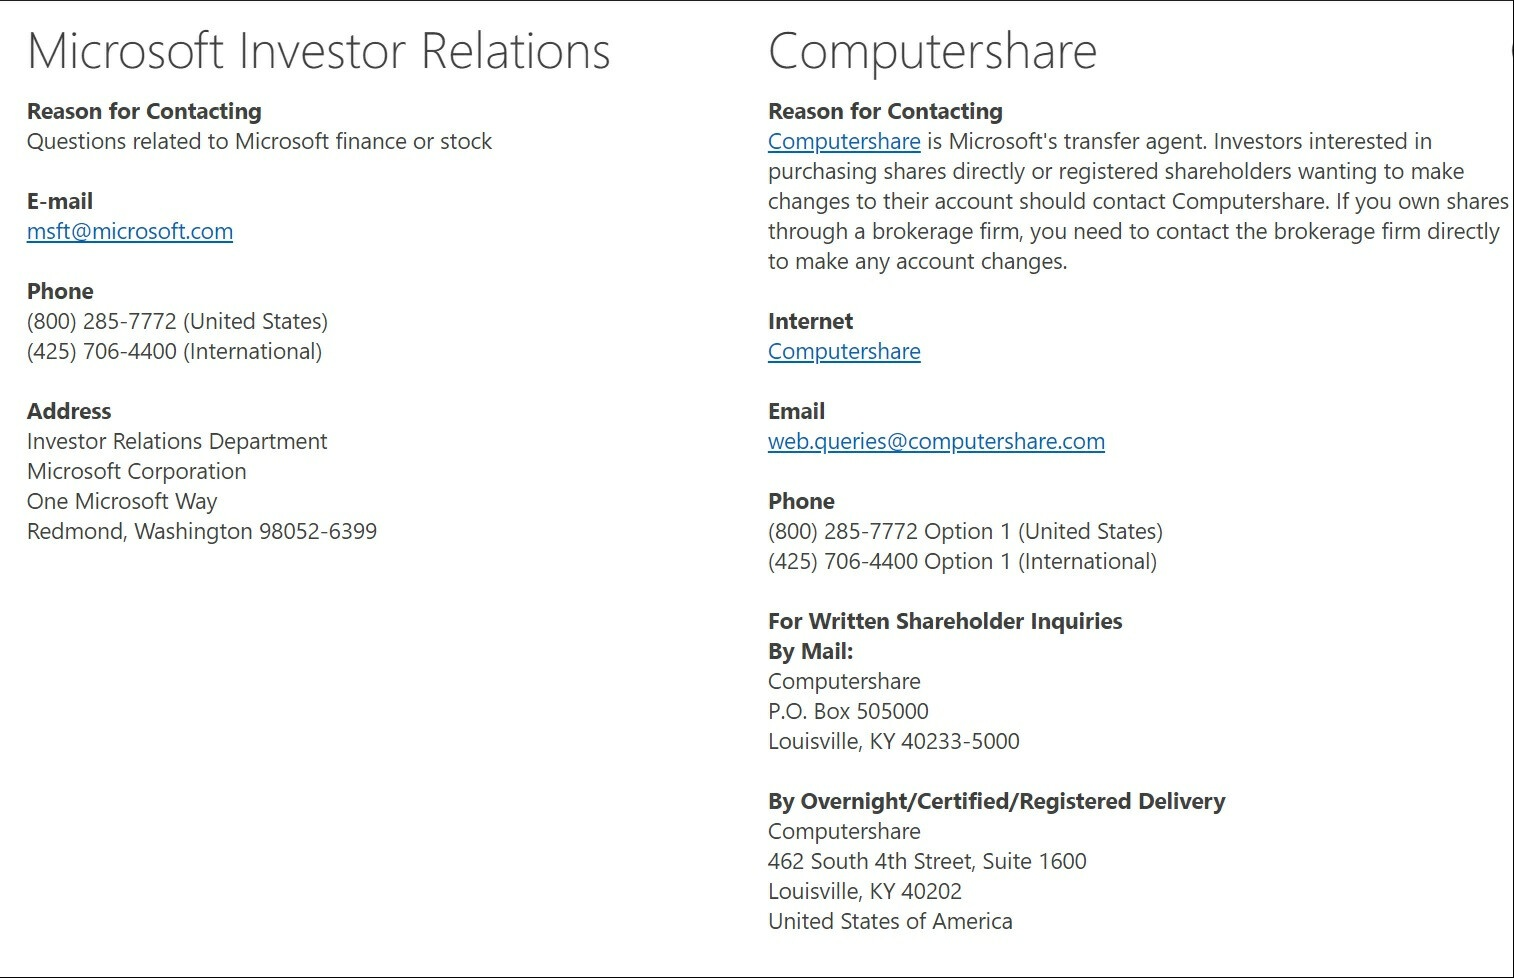

In [18]:
from IPython.display import Image
import base64
from azure.storage.blob import ContainerClient
count = 0
container = ContainerClient.from_connection_string(conn_str=STORAGECONNSTRING, container_name=know_store_container)
blob_list = container.list_blobs()
for blob in blob_list:
    print(blob.name + '\n')
    blob_client = container.get_blob_client(blob.name)
    with open("image" + str(count) + ".jpg", "wb") as my_blob:
                download_stream = blob_client.download_blob()
                my_blob.write(download_stream.readall())
    count = count + 1
    if(count == 3):
        break

Image(filename='image0.jpg') 

### Next Steps
In this exercise, you learned how to pass images into skills and return the modified images to the skillset for further processing. 

As a next step, you can start from scratch and build a [custom AML Skill](https://docs.microsoft.com/azure/search/cognitive-search-aml-skill) to perform inferences on images, or use the Custom Vision service to build a skill. The power skills github repository has a [sample custom vision skill](https://github.com/Azure-Samples/azure-search-power-skills/tree/master/Vision/CustomVision) to help you get started.